# Business Understanding

Skin cancer is one of the most common types of cancer in the world. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. According to the [World Cancer Research Fund](https://www.wcrf.org/dietandcancer/skin-cancer-statistics/), Australia has the highest rate of Melanoma per capita. [Cancer Australia](https://www.canceraustralia.gov.au/cancer-types/melanoma/statistics) estimates close to 17,000 new cases of Melanoma have been diagnosed in 2021, resulting in over 1,000 deaths this year. 

Unlike other cancers though, skin cancer can be visibly seen. By using image classification tools, my work aims to accurately predict if a skin lesion is malignant or benign. By identifying if the skin has Melanoma early on, lives can be saved. My hope is that you, the Australian Department of Health, would use your resources in conjuction with my model to develop and market an app for the benefit of your citizens. Using their mobile phone, they can easily take a picture and recognize whether they need to go to a dermatologist for further diagnosis.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
#! pip freeze

In [3]:
#Other necessary imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Source for calculating predictions for confusion matrix: <br>
https://stackoverflow.com/questions/69875073/confusion-matrix-valueerror-classification-metrics-cant-handle-a-mix-of-binary

In [4]:
#Function to Evaluate Final Model
def evaluate_final_model(model, x_test, y_test):
    '''
    Source for plotting confusion matrix:
    https://stackoverflow.com/questions/69875073/confusion-matrix-valueerror-classification-metrics-cant-handle-a-mix-of-binary
    
    Evaluate model by displaying confusion matrix of testing data, 
    and also by displaying a DataFrame with Loss, Accuracy, Recall, and AUC-ROC for testing data
    
    Input: 
    -final model to be evaluated
    -x_test: numpy array of images from testing data
    -y_test: numpy array of target values from testing data
    
    Output:
    -Confusion matrix of y_test and model predictions
    -DataFrame with Loss, Accuracy, Recall, and AUC-ROC for test dataset
    '''
    #Calculated Prediction
    y_preds = model.predict(x_test)
    y_preds = y_preds.flatten()
    y_preds = np.where(y_preds > 0.5, 1, 0)
    
    #Plot Confusion Matrix of with Counts
    cm_counts = confusion_matrix(y_test, y_preds)
    sns.heatmap(cm_counts, annot=True, fmt = 'd', cmap = 'summer', xticklabels=['Predicted Benign', 'Predicted Malignant'],
                yticklabels=['Is Benign', 'Is Malignant'])
    plt.yticks(rotation=0)
    plt.title("Confusion Matrix w/ Counts")
    plt.show()
    
    #Plot Confusion Matrix normalized
    cm_norm = confusion_matrix(y_test, y_preds, normalize = 'all')
    sns.heatmap(cm_norm, annot=True, fmt = '.2%', cmap = 'summer', xticklabels=['Predicted Benign', 'Predicted Malignant'],
                yticklabels=['Is Benign', 'Is Malignant'])
    plt.yticks(rotation=0)
    plt.title("Confusion Matrix w/ Normalization")
    plt.show()
    
    #Plot Confusion Matrix based on True
    cm_true = confusion_matrix(y_test, y_preds, normalize = 'true')
    sns.heatmap(cm_true, annot=True, fmt = '.2%', cmap = 'summer', xticklabels=['Predicted Benign', 'Predicted Malignant'],
                yticklabels=['Is Benign', 'Is Malignant'])
    plt.yticks(rotation=0)
    plt.title("Confusion Matrix based on True Label")
    plt.show()
    
    #Create a DataFrame with the results 
    model_test = model.evaluate(x_test, y_test, verbose=0)
    model_results = {"Test Dataset":[]};
    for i in range(4):
        model_results['Test Dataset'].append(round(model_test[i],3))
    model_results_df = pd.DataFrame.from_dict(data = model_results,
                                                   orient = 'index', 
                                                   columns = ['Loss', 'Accuracy', 'Recall', 'AUC-ROC'])
    display(model_results_df)

# Data Understanding

The data was created by the [Society for Imaging Informatics in Medicine (SIIM)](https://siim.org/) and [International Skin Imaging Collaboration (ISIC)](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main). SIIM is the leading healthcare organization for informatics in medical imaging who's mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. ISIC is an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesion. I was able to use the data through the [SIIM-ISIC Melanoma Classification competition](https://www.kaggle.com/c/siim-isic-melanoma-classification/overview) on Kaggle.

The following is the citation of the original dataset under CC BY-NC 4.0:

> The ISIC 2020 Challenge Dataset https://doi.org/10.34970/2020-ds01 (c) by ISDIS, 2020
> 
> Creative Commons Attribution-Non Commercial 4.0 International License.
> 
> The dataset was generated by the International Skin Imaging Collaboration (ISIC) and images are from the following sources: Hospital Clínic de Barcelona, Medical University of Vienna, Memorial Sloan Kettering Cancer Center, Melanoma Institute Australia, Sydney Melanoma Diagnostic Centre, University of Queensland, and the University of Athens Medical School.
> 
> You should have received a copy of the license along with this work.
> 
> If not, see https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt.

One limitation of the dataset is the size of images. Since the images had different sizes and were too large for my code to run, I used resized images, found [here](https://www.kaggle.com/cdeotte/jpeg-melanoma-512x512). Another major limitation from this dataset is how imbalanced the target is. 98% of the over 33,000 images were classified as benign. To combat this imbalance, I added only the malignant images from the 2019 SIIM-ISIC Melanoma Classification competition, found [here](https://www.kaggle.com/cdeotte/jpeg-isic2019-512x512) and the malignant images that weren't used in the 2019 or 2020 competitions, found [here](https://www.kaggle.com/cdeotte/malignant-v2-512x512). Since the images came from the same source, [ISIC](https://challenge.isic-archive.com/data/), and there was no fundamental difference between the way they were taken, I'm not worried about creating a bias toward these newly added malignant images.

In [5]:
#Find path for images and csv files
root_path = '../input/jpeg-melanoma-512x512/'
print(list(os.listdir(root_path)))

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']


In [6]:
#Read in training csv
df = pd.read_csv(root_path + 'train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [7]:
#Look at DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


In [8]:
#Check the number of nulls in each column
df.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
tfrecord                           0
width                              0
height                             0
dtype: int64

In [9]:
#Check and see if any image names are duplicates
print(f"Does Image Name have any duplicates?: {df['image_name'].nunique() != len(df['image_name'])}")

Does Image Name have any duplicates?: False


In [10]:
#Get diagnosis value counts
df['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [11]:
#Check if target only includes melanoma diagnosis
df[df['diagnosis']=='melanoma']['target'].value_counts()

1    584
Name: target, dtype: int64

In [12]:
df[df['diagnosis']!='melanoma']['target'].value_counts()

0    32542
Name: target, dtype: int64

Create a column for each jpeg path<br>
Source: https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations#4.-Preprocess-.csv-files-%F0%9F%93%90

In [13]:
#Add a column with the path to each images jpeg
df['path_jpeg'] = root_path + 'train/' + df['image_name'] + '.jpg'
print(df['image_name'][0])
print(df['path_jpeg'][0])

ISIC_2637011
../input/jpeg-melanoma-512x512/train/ISIC_2637011.jpg


In [14]:
#Check target distribution
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [15]:
#Check target distribution normalized
df['target'].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [16]:
#Check benign_malignant distribution
df['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [17]:
#Double check that whenever target = 0, benign_malignant = 'benign', and vice versa
print(df[df['target']==0]['benign_malignant'].value_counts())
print(df[df['target']==1]['benign_malignant'].value_counts())

benign    32542
Name: benign_malignant, dtype: int64
malignant    584
Name: benign_malignant, dtype: int64


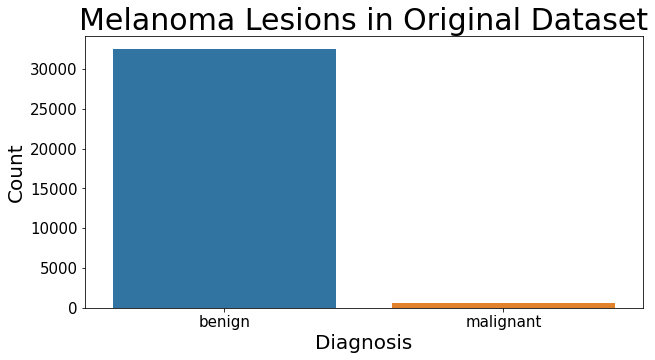

In [18]:
#Visualize Melanoma lesion distribution
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df, x = 'benign_malignant')
ax.set_xlabel(xlabel = 'Diagnosis', fontsize = 20)
ax.set_ylabel(ylabel = 'Count', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Melanoma Lesions in Original Dataset", fontsize = 30)
plt.show()

The target is heavily unbalanced. Let's add more malignant images from past competitions to help combat this.

## Load Malignant Images From 2019 Competition

Read in the 2019 data (includes images from 2018 and 2017 competitions) <br> Source: https://www.kaggle.com/cdeotte/jpeg-isic2019-512x512

In [19]:
#Read in 2019 dataset
df_2019 = pd.read_csv("../input/jpeg-isic2019-512x512/train.csv")

#Create a column with path of image
df_2019['path_jpeg'] = "../input/jpeg-isic2019-512x512/train/" + df_2019['image_name'] + ".jpg"
print(df_2019['path_jpeg'][0]) #Sanity Check

../input/jpeg-isic2019-512x512/train/ISIC_0000000.jpg


In [20]:
#Check information from 2019 dataset
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     25331 non-null  object 
 1   patient_id                     25331 non-null  int64  
 2   sex                            25331 non-null  object 
 3   age_approx                     24894 non-null  float64
 4   anatom_site_general_challenge  22700 non-null  object 
 5   diagnosis                      25331 non-null  object 
 6   benign_malignant               25331 non-null  object 
 7   target                         25331 non-null  int64  
 8   tfrecord                       25331 non-null  int64  
 9   width                          25331 non-null  int64  
 10  height                         25331 non-null  int64  
 11  path_jpeg                      25331 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usag

In [21]:
#Print out the target distribution
print(df_2019['target'].value_counts())
print(df_2019['benign_malignant'].value_counts())

0    20809
1     4522
Name: target, dtype: int64
benign       20809
malignant     4522
Name: benign_malignant, dtype: int64


In [22]:
#Check that only melanoma skin cancer is considered malignant
df_2019[df_2019['diagnosis']=='MEL']['benign_malignant'].value_counts()

malignant    4522
Name: benign_malignant, dtype: int64

In [23]:
#Create a new dataframe with only malignant images
df_2019_malignant = df_2019[df_2019['benign_malignant']=='malignant']
df_2019_malignant

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path_jpeg
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,../input/jpeg-isic2019-512x512/train/ISIC_0000...
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,../input/jpeg-isic2019-512x512/train/ISIC_0000...
12,ISIC_0000013,-1,female,30.0,posterior torso,MEL,malignant,1,20,1022,767,../input/jpeg-isic2019-512x512/train/ISIC_0000...
21,ISIC_0000022_downsampled,-1,female,55.0,lower extremity,MEL,malignant,1,14,1024,768,../input/jpeg-isic2019-512x512/train/ISIC_0000...
25,ISIC_0000026_downsampled,-1,female,30.0,lower extremity,MEL,malignant,1,14,1024,768,../input/jpeg-isic2019-512x512/train/ISIC_0000...
...,...,...,...,...,...,...,...,...,...,...,...,...
25316,ISIC_0073231,-1,female,55.0,anterior torso,MEL,malignant,1,17,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...
25319,ISIC_0073237,-1,female,45.0,lower extremity,MEL,malignant,1,11,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...
25320,ISIC_0073238,-1,female,45.0,upper extremity,MEL,malignant,1,11,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...
25322,ISIC_0073241,-1,male,60.0,palms/soles,MEL,malignant,1,13,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...


## Load More Unused Malignant Images

Read in more jpg images that weren't from 2020,2019,2018, or 2017 <br> Source: https://www.kaggle.com/cdeotte/malignant-v2-1024x1024

In [24]:
#Add more malignant images that weren't used in 2020, 2019, 2018, or 2017 but were still on the ISIM website
df_more = pd.read_csv("../input/malignant-v2-512x512/train_malig_2.csv")

#Create a column with the path to each image
df_more['path_jpeg'] = "../input/malignant-v2-512x512/jpeg512/" + df_more['image_name'] + ".jpg"
print(df_more['path_jpeg'][0]) #Sanity Check

../input/malignant-v2-512x512/jpeg512/ISIC_0000070.jpg


In [25]:
#View information of DataFrame
df_more.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     580 non-null    object 
 1   patient_id                     580 non-null    int64  
 2   sex                            547 non-null    object 
 3   age_approx                     557 non-null    float64
 4   anatom_site_general_challenge  471 non-null    object 
 5   diagnosis                      554 non-null    object 
 6   benign_malignant               580 non-null    object 
 7   target                         580 non-null    int64  
 8   width                          580 non-null    int64  
 9   height                         580 non-null    int64  
 10  source                         580 non-null    object 
 11  ext                            580 non-null    object 
 12  tfrecord                       580 non-null    int

In [26]:
#Check that target column and benign_malignant column have the same value counts
print(df_more['target'].value_counts())
print(df_more['benign_malignant'].value_counts())

1    580
Name: target, dtype: int64
malignant    580
Name: benign_malignant, dtype: int64


## Combine 3 DataFrames into 1

In [27]:
#Combine the 3 DataFrames into 1
df_combined = pd.concat([df, df_2019_malignant, df_more])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38228 entries, 0 to 579
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     38228 non-null  object 
 1   patient_id                     38228 non-null  object 
 2   sex                            38130 non-null  object 
 3   age_approx                     38052 non-null  float64
 4   anatom_site_general_challenge  37465 non-null  object 
 5   diagnosis                      38202 non-null  object 
 6   benign_malignant               38228 non-null  object 
 7   target                         38228 non-null  int64  
 8   tfrecord                       38228 non-null  int64  
 9   width                          38228 non-null  int64  
 10  height                         38228 non-null  int64  
 11  path_jpeg                      38228 non-null  object 
 12  source                         580 non-null    o

In [28]:
#Check the value counts for benign or malignant images
df_combined['benign_malignant'].value_counts(normalize=True)

benign       0.851261
malignant    0.148739
Name: benign_malignant, dtype: float64

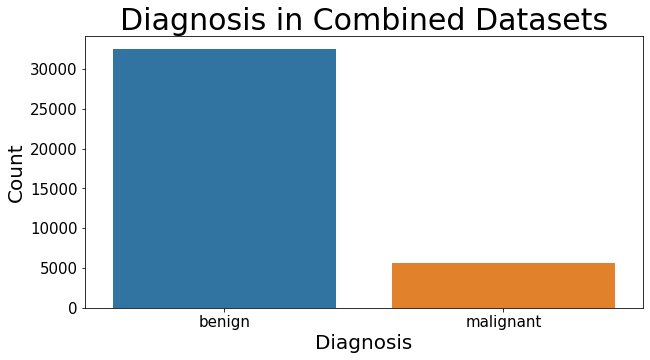

In [29]:
#Visualize the new distribution
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_combined, x = 'benign_malignant')
ax.set_xlabel(xlabel = 'Diagnosis', fontsize = 20)
ax.set_ylabel(ylabel = 'Count', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Diagnosis in Combined Datasets", fontsize = 30)
plt.show()

## Visualize Images

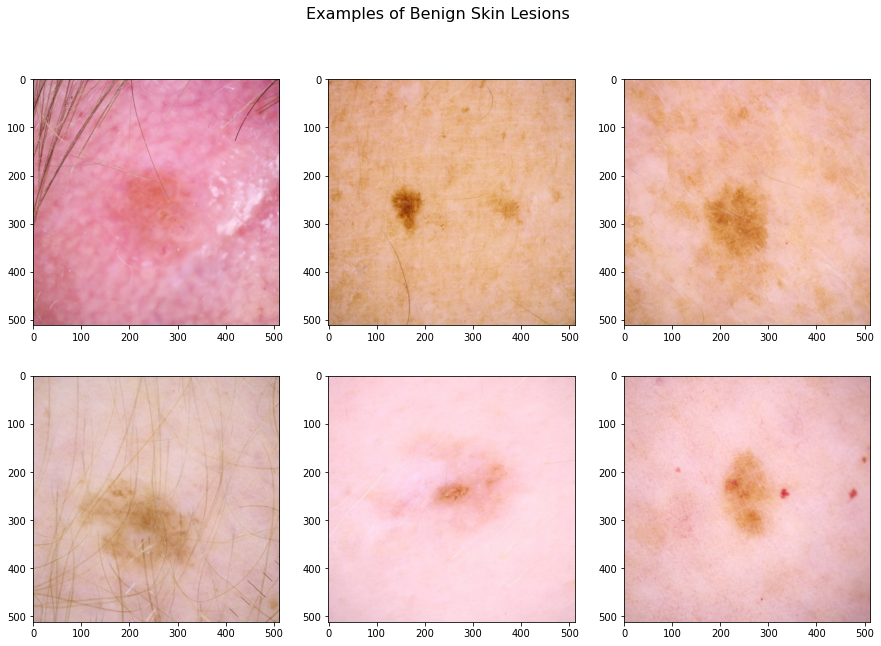

In [30]:
#Visualize the 6 benign lesions in the Dataframe
benign_df = df_combined[df_combined['benign_malignant']=='benign']
#I handpicked a couple images for illustration purposes
benign_images = benign_df['path_jpeg'].iloc[[0,1,4,6,8,9]] 
plt.figure(figsize=(15,10))
for i in range(6):
    plt.suptitle('Examples of Benign Skin Lesions', fontsize = 16)
    plt.subplot(2,3,i+1)
    img = plt.imread(benign_images.iloc[i])
    plt.imshow(img)

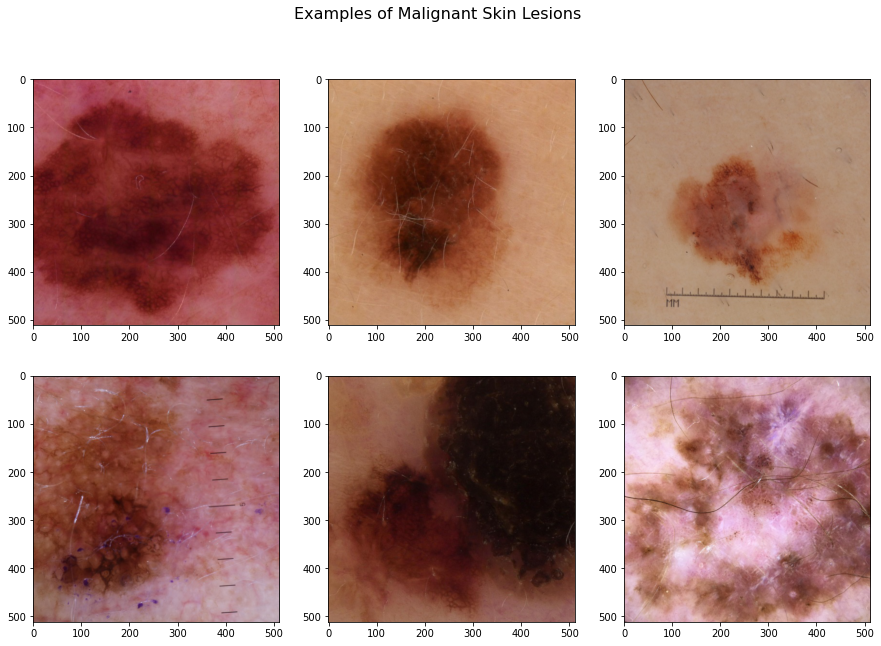

In [31]:
#Visualize 6 malignant lesions in the DataFrame
malignant_df = df_combined[df_combined['benign_malignant']=='malignant']
#I handpicked a couple images for illustration purposes
malignant_images = malignant_df['path_jpeg'].iloc[[8,12,13,15,16,18]] 
plt.figure(figsize=(15,10))
for i in range(6):
    plt.suptitle('Examples of Malignant Skin Lesions', fontsize = 16)
    plt.subplot(2,3,i+1)
    img = plt.imread(malignant_images.iloc[i])
    plt.imshow(img)

# Data Preparation

In order to truely evaluate my model on unseen data, I performed 2 `train_test_split()`. This prevents data leakage. The first split resulted in the 10% of the data going to the testing set. I will hold this data until the very end, allowing me to evaluate the final model on unseen data. The second split resulted in 67.5% going to the training set, and 22.5% going to the validation set. These 2 sets is what I will use to evaluate all my model iterations and decide what model should be my final model.

For each dataset, I used the `ImageDataGenerator` class, imported from `Keras`, to generate batches of normalized tensor image data, rescaling the values so that they're between 0 and 1. With this class, I used the `flow_from_dataframe()` method to locate the images. Using the `target_size` parameter inside this method, I resized the images down to 128x128 for memory purposes.

Another consequence of having limited memory capactiy on Kaggle was that I was forced to divide the batch size of my training data by 3. The implications of this meant that my models were training on only 8,601 images, 7,321 were benign and 1,279 were malignant. This means over 17,000 weren't seen which may result in a bias toward this first batch of training images. For this current summary notebook, I loaded the processed data from my EDA-and-Data-Preprocessing notebook, found on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/eda-and-data-preprocessing.ipynb) and [Kaggle](https://www.kaggle.com/garrettwilliams90/eda-and-data-preprocessing).  

## Train/Test Split

In [32]:
#Make 2 Train test splits so that we are left with:
#X_train -> 67.5% of data
#X_val -> 22.5% of data
#X_test -> 10% of data
X = df_combined[['path_jpeg']]
y = df_combined['benign_malignant']
X_use, X_test, y_use, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_use, y_use, test_size=0.25, random_state=42, stratify=y_use)

In [33]:
#Combine the training data back together into 1 DataFrame
train_df = pd.concat([X_train, y_train], axis=1)
train_df

,path_jpeg,benign_malignant
32605,../input/jpeg-melanoma-512x512/train/ISIC_9843...,benign
20810,../input/jpeg-melanoma-512x512/train/ISIC_6322...,benign
28419,../input/jpeg-melanoma-512x512/train/ISIC_8600...,benign
1083,../input/jpeg-melanoma-512x512/train/ISIC_0429...,benign
15723,../input/jpeg-melanoma-512x512/train/ISIC_4807...,benign
...,...,...
5549,../input/jpeg-melanoma-512x512/train/ISIC_1758...,benign
12224,../input/jpeg-melanoma-512x512/train/ISIC_3761...,benign
4822,../input/jpeg-melanoma-512x512/train/ISIC_1548...,benign
19305,../input/jpeg-melanoma-512x512/train/ISIC_5863...,benign


In [34]:
#Combine the validation data back together into 1 DataFrame
val_df = pd.concat([X_val, y_val], axis=1)
val_df

,path_jpeg,benign_malignant
13964,../input/jpeg-melanoma-512x512/train/ISIC_4282...,benign
6875,../input/jpeg-melanoma-512x512/train/ISIC_2153...,benign
8167,../input/jpeg-melanoma-512x512/train/ISIC_2543...,benign
2475,../input/jpeg-melanoma-512x512/train/ISIC_0840...,benign
5880,../input/jpeg-melanoma-512x512/train/ISIC_1862...,benign
...,...,...
21344,../input/jpeg-melanoma-512x512/train/ISIC_6477...,benign
20959,../input/jpeg-melanoma-512x512/train/ISIC_6367...,benign
1006,../input/jpeg-melanoma-512x512/train/ISIC_0409...,benign
8070,../input/jpeg-isic2019-512x512/train/ISIC_0029...,malignant


In [35]:
#Combine the test data back together into 1 DataFrame
test_df = pd.concat([X_test, y_test], axis=1)
test_df

,path_jpeg,benign_malignant
14363,../input/jpeg-melanoma-512x512/train/ISIC_4398...,benign
20516,../input/jpeg-melanoma-512x512/train/ISIC_6244...,benign
15690,../input/jpeg-melanoma-512x512/train/ISIC_4794...,benign
22253,../input/jpeg-melanoma-512x512/train/ISIC_6742...,benign
5718,../input/jpeg-melanoma-512x512/train/ISIC_1812...,benign
...,...,...
3861,../input/jpeg-melanoma-512x512/train/ISIC_1262...,benign
28322,../input/jpeg-melanoma-512x512/train/ISIC_8574...,benign
1898,../input/jpeg-melanoma-512x512/train/ISIC_0668...,benign
27219,../input/jpeg-melanoma-512x512/train/ISIC_8244...,benign


In [36]:
#Double check target distribution in train DataFrame
train_df['benign_malignant'].value_counts(normalize=True)

benign       0.851258
malignant    0.148742
Name: benign_malignant, dtype: float64

In [37]:
#Double check target distribution in train DataFrame
val_df['benign_malignant'].value_counts(normalize=True)

benign       0.851314
malignant    0.148686
Name: benign_malignant, dtype: float64

## Image Processing

I saved the data on my EDA-and-Data-Preprocessing notebook, found on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/eda-and-data-preprocessing.ipynb) and [Kaggle](https://www.kaggle.com/garrettwilliams90/eda-and-data-preprocessing). Personally, I could only use a third of the training data because of memory limitations. I loaded the full processed training data as well for reference.

In [38]:
#Load processed image data data
train_images = np.load('../input/eda-and-data-preprocessing/train_images.npy')
train_labels = np.load('../input/eda-and-data-preprocessing/train_labels.npy')

#A third of the training set 
train_images_third = np.load('../input/eda-and-data-preprocessing/train_images_third.npy')
train_labels_third = np.load('../input/eda-and-data-preprocessing/train_labels_third.npy')

val_images = np.load('../input/eda-and-data-preprocessing/val_images.npy')
val_labels = np.load('../input/eda-and-data-preprocessing/val_labels.npy')

test_images = np.load('../input/eda-and-data-preprocessing/test_images.npy')
test_labels = np.load('../input/eda-and-data-preprocessing/test_labels.npy')

In [39]:
#Checking classes
print("Train data set classes:",np.unique(train_labels))
print("Validation data set classes:",np.unique(val_labels))
print("Test data set classes:",np.unique(test_labels))

Train data set classes: [0 1]
Validation data set classes: [0 1]
Test data set classes: [0 1]


In [40]:
#Explore the dataset again
print ("Number of training samples: " + str(train_images.shape[0]))
print ("A third of training samples: " + str(train_images_third.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("===")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("A third of train_images shape: " + str(train_images_third.shape))
print ("A third of train_labels shape: " + str(train_labels_third.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 25803
A third of training samples: 8601
Number of validation samples: 8602
Number of testing samples: 3823
===
train_images shape: (25803, 128, 128, 3)
train_labels shape: (25803,)
A third of train_images shape: (8601, 128, 128, 3)
A third of train_labels shape: (8601,)
val_images shape: (8602, 128, 128, 3)
val_labels shape: (8602,)
test_images shape: (3823, 128, 128, 3)
test_labels shape: (3823,)


# Modeling

I ran 6 different models, fitting to the training set and evaluating on the validation set:
- Simple Baseline Model
- Convolutional Neural Network
- Convolutional Neural Network with Dropout Layers
- Pretrained VGG16
- Pretrained ResNet50
- Pretrained InceptionResNetV2

The key metrics I focused on were Accuracy, Recall, and AUC-ROC. I focuesed on Recall because having False Negatives are more costly than having False Positives. False Negatives is having a malignant skin lesion but predicting that it's benign. This would result in people thinking they're healthy when they arent, which could result in lives being lost.

A function was defined at the top of each modeling iteration notebook to visualize the training and validation results. The source of inspiration for my code was [Lindsey Berlin](https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb).

## Baseline Understanding

Source for displaying value counts of numpy array: https://www.kite.com/python/answers/how-to-count-frequency-of-unique-values-in-a-numpy-array-in-python

In [41]:
#Baseline Understanding
(unique, counts) = np.unique(val_labels, return_counts=True)
frequencies = np.asarray((unique, counts/val_labels.shape[0])).T
print(frequencies)

[[0.         0.85131365]
 [1.         0.14868635]]


85.1% of the validation images are benign and 14.9% of the validation images are malignant. This means that the models accuracy would be 85% if it always predicted 0. And if these were the case, the recall score would equal 0 because there are no True Positives. This is another reason why I focused on increasing Recall.

## 1st Iteration: Simple Baseline Model

I used `keras` to create a neural network model with an input layer of 12 nodes and 2 hidden dense layers with 7 and 5 nodes respectively. You can visit my notebook on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/Model_Iterations/baseline-model.ipynb) or [Kaggle](https://www.kaggle.com/garrettwilliams90/baseline-model) to view the whole notebook. I only imported the model and final evaluations on the validation dataset.

In [42]:
#Load baseline model
baseline_model = load_model('../input/baseline-model/best_baseline_model.h5')

#View summary of baseline model
baseline_model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 128, 12)      48        
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1376263   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,376,357
Trainable params: 1,376,357
Non-trainable params: 0
_________________________________________________________________


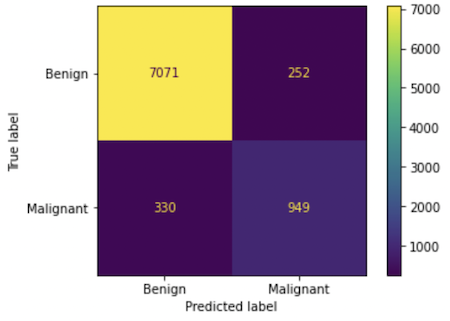

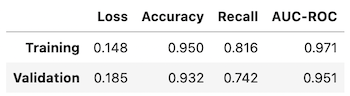

The model performed surprisingly well for such a simply model. There is a 7% difference in Recall scores but at least validation didn't have a 0.0 score. It doesn't seem to be overfitting and I think 93% accuracy is pretty good but there is no way to know without running a few more model iterations. 

## 2nd Iteration: Convolutional Neural Network Model

For the second iteration, I used a Convolutional Neural Network (CNN) because they are widely considered the gold standard for image recognition. This model 3 hidden layers, 2 of which are convolutional. For now, I only loaded the model and displayed the evaluation visuals. You can view the entire process in notebook on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/Model_Iterations/first-cnn-model.ipynb) or [Kaggle](https://www.kaggle.com/garrettwilliams90/first-cnn-model). 

In [43]:
#Load first cnn model
first_cnn_model = load_model('../input/first-cnn-model/best_cnn_model.h5')

#View summary of CNN model
first_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

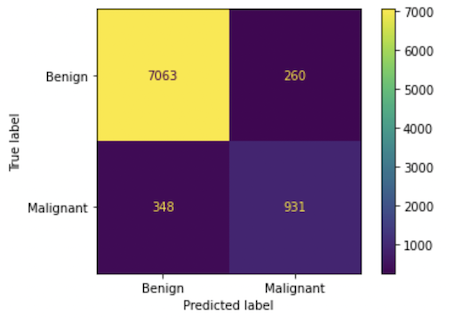

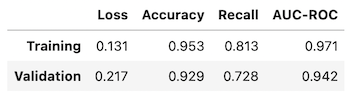

The results from this model are slightly worse than the baseline model. Maybe our model will improve if we add some dropout layers. At the very least it should eliminate the overfitting. 

## 3rd Iteration: Convolutional Neural Network with Dropout Layers

This model is almost identical to the previous but we also add some dropout layers after the 2 hidden convolutional layers. For memory purposes, I'm only importing the model from the notebook I created it in which can be found on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/Model_Iterations/second-cnn-model.ipynb) and [Kaggle](https://www.kaggle.com/garrettwilliams90/second-cnn-model).

In [44]:
#Load second cnn model with dropouts
second_cnn_model = load_model('../input/second-cnn-model/best_cnn2_model.h5')

#View summary of previous CNN model but with Dropout layers
second_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

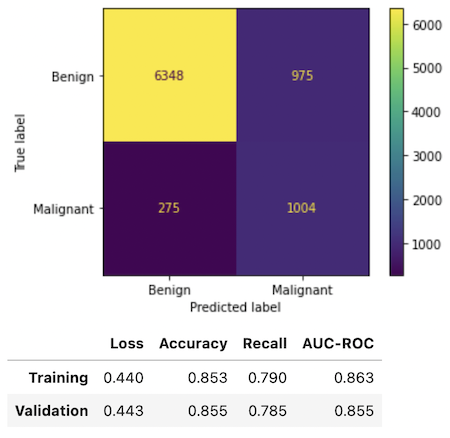

Even though the model is not overfit anymore and Recall improved by about 6%, Accuracy and AUC-ROC declined by close to 10%. Instead of spending too much time trying to figure how many layers, nodes, or features to add in order to improve all metrics, let's try some iterations on pretrained neural networks.

## 4th Iteration: VGG16 Model

A pretrained network consists of layers that have already been trained on general data. For images, these layers have already learned general patterns, textures, colors, etc. such that when you feed in your training data, certain features can immediately be detected. VGG16 is a simple and widely used CNN, a great starting point for our pretrained models. I'm only importing the model from the notebook I created it in which can be found on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/Model_Iterations/vgg16-model.ipynb) and [Kaggle](https://www.kaggle.com/garrettwilliams90/vgg16-model).

In [45]:
#Load VGG16 model
vgg16_model = load_model('../input/vgg16-model/best_vgg16_model.h5')

#View summary of VGG16 model
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


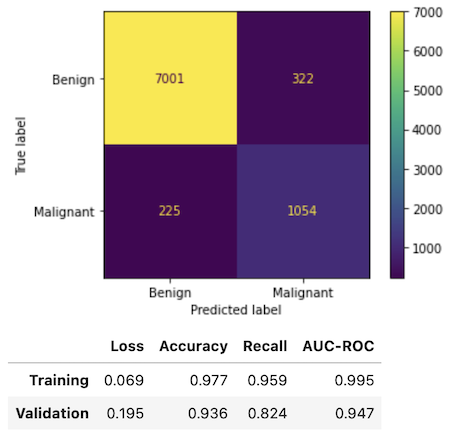

Wow! The VGG16 model has given us our highest accuracy and recall score yet. I believe this is the best model yet but let's see if another pretrained model can beat it.

## 5th Iteration: ResNet50 Model

ResNet50 is another popular pretrained neural network. I'm loading the model from the notebook I created it in which can be found on [Github](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/Model_Iterations/resnet50-model.ipynb) and [Kaggle](https://www.kaggle.com/garrettwilliams90/resnet50-model).

In [46]:
#Load ResNet50 model
resnet50_model = load_model('../input/resnet50-model/best_resnet50_model.h5')

#View summary of ResNet50 model
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 27,782,273
Trainable params: 4,194,561
Non-trainable params: 23,587,712
_________________________________________________________________


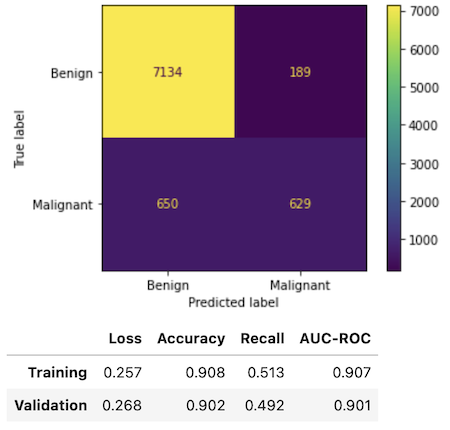

Well, that's upsetting. All of our scores decreased, especially recall which went below 50%. 

## 6th Iteration: InceptionResNetV2 Model

Last but not least, I chose InceptionResNetV2 as the final model iteration. According to keras's [list](https://keras.io/api/applications/) of pretrained neural networks, InceptionResNetV2 had one of the highest accuracy scores in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. I loaded the model and results from another one of my notebooks, found on [GitHub](https://github.com/garrettwilliams90/MelanomaClassification/blob/main/Notebooks/Model_Iterations/inceptionresnetv2-model.ipynb) and [Kaggle](https://www.kaggle.com/garrettwilliams90/inceptionresnetv2-model). 

In [47]:
#Load InceptionResNet model
inception_resnet_model = load_model('../input/inceptionresnetv2-model/best_inceptionResNet_model.h5')

#View summary of InceptionResNetV2 Model
inception_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               786560    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 55,123,425
Trainable params: 786,689
Non-trainable params: 54,336,736
_________________________________________________________________


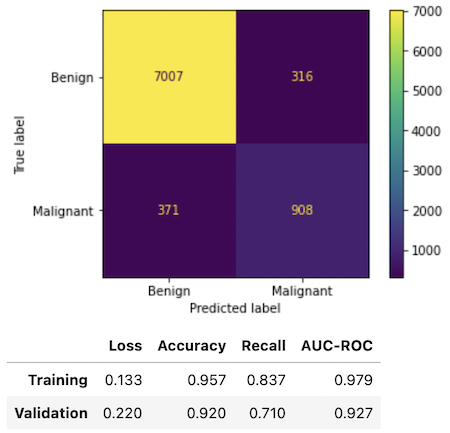

Our results are not too different than our baseline model and first CNN model, but it's not our best model.

# Evaluation

The final model will be the VGG16 because it predicted the highest accuracy and recall score, while not overfitting too much to the training data. Again, recall is the second evaluation metric because a low score would mean our model is predicting a skin lesion is benign when it's actually malignant. This implies you're healthy when you actually aren't and need to seek medical assistance. Now, I'll take our VGG16 model and evaluate it on the testing set, which I held out at the begining. This is so I can truly evaluate our model on unseen images.

In [48]:
#Instantiate Final Model
final_model = vgg16_model

#View summary of Final Model
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


2021-12-02 21:16:13.837742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


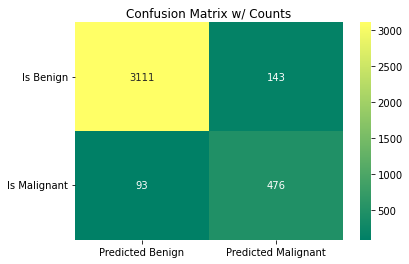

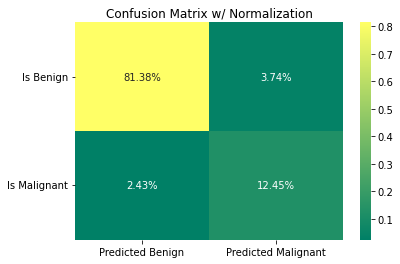

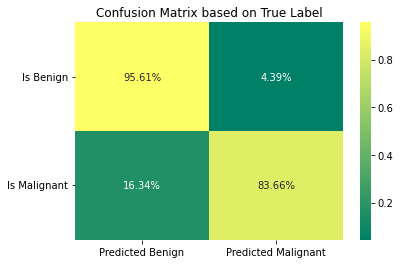

,Loss,Accuracy,Recall,AUC-ROC
Test Dataset,0.199,0.938,0.837,0.948


In [49]:
#Evaluate Final Model on Test Set
evaluate_final_model(final_model, test_images, test_labels)

In [50]:
#Save Final Model
final_model.save("/kaggle/working/final_model.h5")

My model accurately predicts the diagnosis of a skin lesion 93.8% of the time and incorrectly labels the lesion as benign on 16.3% of the time. As a reminder, my baseline understanding had an accuracy of 85.1% and a recall score of 0.

# Conclusion

The Australian Department of Health can develop and market a mobile app for the public that uses my model to classify if a person has melanoma or not. This would result in quicker reactions to seek out professionally-trained Dermatologists, which could save lives. 

In the future, if I had more time to work on this project, I'd use tools to combat the class imbalance, like `SMOTE` and `class_weight`, or even undersampling the benign class. This last option would also result in more memory on Kaggle, allowing the model to learn from the enitre training set (not just a third). Another way to free up more memory is to resize the images to something smaller, like 64x64, but this could mean the model isn't learning as much. Lastly, with the ultimate goal of improving the model, I'd try image augmentation, and increaing the epochs and patience to allow for the model to run longer. 